## Описание проекта, загрузка и подготовка данных

### Введение
______
**Название проекта**  

Определение рыночной стоимости автомобиля клиента сервисом по продаже автомобилей с пробегом «Не бит, не крашен».
_____

**Цель исследования**  

Построение моделей для предсказания рыночной стоимости автомобиля клиента с учетом качества предсказания и времени обучения модели.
_______
**Задачи исследования**

- Провести необходимую предобработку датасетов с данными о параметрах автомобиля
- Провести исследовательский анализ данных с учетом их типа
- Провести корреляционный анализ категориальных и количественных признаков
- Построить модели для предсказания рыночной стоимости автомобиля клиента
- Провести сравнительный анализ времени обучения и качества моделей
_____
**Исходные данные**  

Имеются данные, представленные в виде одного датасета, содержащего следующую информацию:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя    
целевой признак:
- `Price` — цена (евро)

### Установка и импорт библиотек

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q
!pip install lightgbm scikit-learn -q
!pip install catboost -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import lightgbm as lgb
import os
import phik
import math
import warnings
import re
import catboost

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy.stats import uniform
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    OneHotEncoder
)
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error
)

In [3]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [4]:
# объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Объявление функций

In [5]:
# функция для краткого обзора датасетов
def view_df(df):
    display(df.head()) 
    display(df.info()) 
    display(df.columns) 
    display(df.describe())

In [6]:
# Функция для определения типа значений в столбце с текстом и числами
def sort_key(val):
    if isinstance(val, str):
        return (1, val)
    return (0, val)

In [7]:
# функция для описания количественных признаков при статистическом анализе
def histbox_plot(df, list_col):
    for name in list_col:
        i = 1
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'Гистограмма и диаграмма размаха признака - {name}', 
                     fontsize = 13, fontweight='bold')
    
        plt.subplot(i, 2, i) 
        sns.histplot(data=df, x=name, kde=True)
    
        plt.subplot(i, 2, i+1)
        sns.boxplot(data=df, x=name)
    
        plt.tight_layout()
        plt.show();
    
        display(df[name].describe())

In [8]:
# функции для описания категориальных признаков при статистическом анализе
# круговая диаграмма
def pie_plot(df, list_col):
    i = 1
    plt.figure(figsize=(12, 12))
    for name in list_col:
        plt.subplot(3, 2, i)
        df[name].value_counts().plot.pie(label='', autopct='%1.0f%%', title=name)
        i +=1

    plt.tight_layout()
    plt.show();
    
# столбчатая диаграмма
def colum_plot(df, list_col):
    i = 1
    plt.figure(figsize=(20, 4))
    for name in list_col:
        plt.subplot(math.ceil(len(list_col) / 2), 2, i)
        order = df[name].value_counts().index
        sns.countplot(data=df, x=name, order=order)
        plt.xticks(rotation=90)
        plt.ylabel('Количество')
        i +=1

    plt.tight_layout()
    plt.show();
    
# столбчатая диаграмма с ограничением по количеству
def colum_n_plot(df, list_col):
    i = 1
    plt.figure(figsize=(20, 4))
    for name in list_col:
        plt.subplot(math.ceil(len(list_col) / 2), 2, i)
        order = df[name].value_counts().index[:30]
        sns.countplot(data=df, x=name, order=order)
        plt.xticks(rotation=90)
        plt.ylabel('Количество')
        i +=1

    plt.tight_layout()
    plt.show();

In [9]:
# функция для построения матрицы Phik
def phik_matrix_(df, interval_cols):
    
    phik_overview = phik_matrix(df, interval_cols=interval_cols) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=f'матрица $\phi_K$',
        fontsize_factor=1,
        figsize=(12, 6)
    )

### Загрузка данных

In [10]:
pth = '/datasets/autos.csv'

if os.path.exists(pth):
     df = pd.read_csv(pth, sep=',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong with loading data')

### Общая информация о датасетах

In [11]:
view_df(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Вывод:** загружена и получена общая информация по датасету:
- имеются пропуски в 5 столбцах: `VehicleType`, `Gearbox`, `Model`,  `FuelType`, `Repaired`
- названия столбцов не соответствуют "змеиному типу"
- имеются аномальные минимумы в столбцах: `Price`, `Power`, `RegistrationMonth`, `RegistrationYear`и аномальные максимумы в столбцах: `RegistrationYear`, `Power`
- неинформативный столбец `NumberOfPictures`
- тип данных соответствуют описанию.     
Более подробный анализ, а также выявление дубликатов, обработка пропусков, аномальных значений и пр. будут произведены на следующих этапах обработки данных

##  Предобработка данных

### Корректировка названий столбцов

In [12]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Обработка неявных дубликатов

In [13]:
for column in df.select_dtypes(exclude=[np.number, np.datetime64]).columns.values:
    print(f"Уникальные значения в колонке '{column}':\n {df[column].unique()}")
    print()

Уникальные значения в колонке 'vehicle_type':
 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения в колонке 'gearbox':
 ['manual' 'auto' nan]

Уникальные значения в колонке 'model':
 ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octav

В значениях рассматриваемых стлобцов неявные дубликаты отсутствуют. Столбец `model` отдельно проанализируем с использованием функции `sort_key`

In [14]:
# Получение уникальных значений и их сортировка
unique_values = df['model'].unique()
sorted_unique_values = sorted(unique_values, key=sort_key)

print(f"Уникальные значения в колонке 'model': {sorted_unique_values}")

Уникальные значения в колонке 'model': [nan, '100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour

В столбце `model` присутствуют неявные дубликаты, заменим их

In [15]:
df['model'] = df['model'].replace('rangerover', 'range_rover')

### Обработка пропусков

In [16]:
df.loc[(df['model'] == 'golf') & (df['brand'] == "volkswagen") 
       & (df['registration_year'] == 1993), 'vehicle_type'].unique()

array([nan, 'sedan', 'small', 'convertible', 'coupe', 'wagon', 'bus',
       'other'], dtype=object)

Восстановить пропуски в категориальных столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`, не представляется возможным по имеющейся информации, необходимо обращение к экспертам. Даже для столбца `vehicle_type` при одинковой марке, моделе и годе выпуска авто присутствует значительное количество вариантов. При условии, что встречающаяся категория `other` в данных столбцах заполнялась корректно, т.е действительно при отутствии необходимой категории, тогда пропуски заменим значением `unk`  (неизвестно).

In [17]:
colum_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
df[colum_nan] = df[colum_nan].fillna('unk')

**Вывод:** по результатам предобработки данных названия столбцов были приведены к "змеиному типу", заменили некорректное наименование марки автомобиля, выявленные в данных пропуски заполнены значением `unk` (неизвестно), таким образом, получена отдельная категория данных.    
Перед началом следующего этапа подготовки данных сохраним оригинальный датасет

In [18]:
df_orig = df

## Подготовка данных

### Предварительный отбор признаков

Проведем предварительный отбор признаков, которые явно не могут иметь отношения к прогнозу целевого признака - `цена`, а именно: `date_crawled`, `date_created`, `last_seen`. Исключим признак `registration_month`, так как в документах на автомобиль, равно как и в объявлениях, не указывается месяц, а только год выпуска, следовательно и объединение этого параметра с `registration_year` не имеет смысла. Также исключим `number_of_pictures`, как признак с нулевой дисперсией, а значит бесполезный для прогнозирования.

In [19]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 
              'registration_month', 'number_of_pictures'], axis=1)

### Обработка явных дубликатов

In [20]:
df.duplicated().sum()

23511

In [21]:
df = df.drop_duplicates()
df.shape[0]

330858

In [22]:
print(f'Доля текущего объема данных относительно первоначального: {df.shape[0]/df_orig.shape[0]:.1%}')

Доля текущего объема данных относительно первоначального: 93.4%


### Исследовательский анализ данных

Выделим количественные и категориальные признаки

In [23]:
num_col_df = df.select_dtypes(include='number').columns.tolist()
cat_col_df = df.select_dtypes(exclude='number').columns.tolist()
print(len(num_col_df + cat_col_df))

11


#### Cтатистический анализ количественных признаков

На этапе загрузки данных в признаках `price`, `registration_year` и `power` были выявлены аномальные значения, обработаем их:  
- для признака `price` исключим значения менее 50 евро как аномальные и малочисленные, а также искажающие общую картину цен на автомобили
- для признака `registration_year` ограничим выборку диапазоном 1980 - 2024 гг, количество автомобилей до 1980 резко снижается и для автомобилей такого возраста цену не имеет смысла прогнозировать, так она определяется уже не рынком, а другими факторами (по цене "металла" или антикварным рынком и пр.)
- для признака `power` ограничим выборку диапазоном 30 - 300 л.с., т.к автомобили с мощностью ниже этого дипазона выпускались исключительно редко, а выше этого диапазона идет так же достаточно редкая категория спорткаров со своим рынком и правилами формирования цены.

In [24]:
df = df.query('price >=50 & 1980 <= registration_year <= 2016 & 30 <= power <= 620')
len(df)

272728

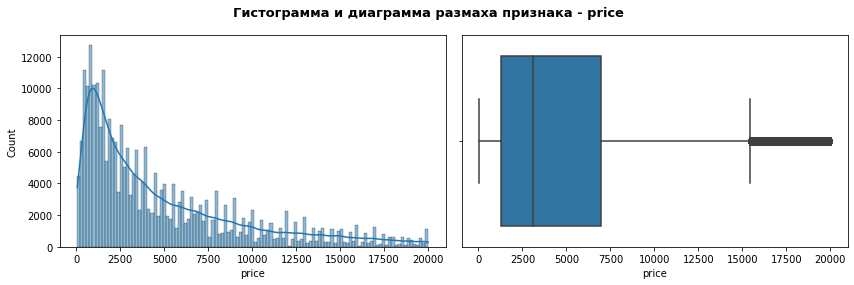

count    272728.000000
mean       4807.949719
std        4592.381065
min          50.000000
25%        1300.000000
50%        3100.000000
75%        6950.000000
max       20000.000000
Name: price, dtype: float64

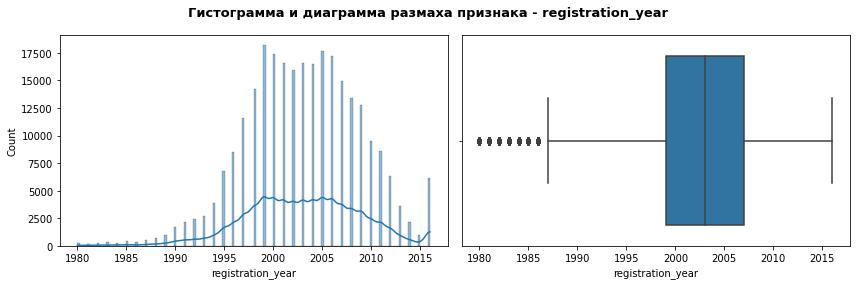

count    272728.000000
mean       2003.042489
std           5.909968
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

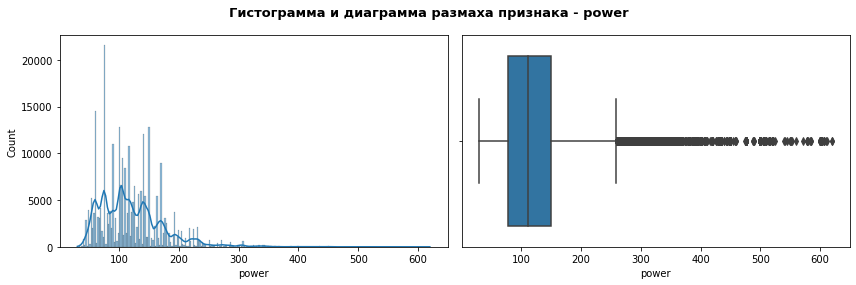

count    272728.000000
mean        120.722753
std          53.572457
min          30.000000
25%          77.000000
50%         111.000000
75%         150.000000
max         620.000000
Name: power, dtype: float64

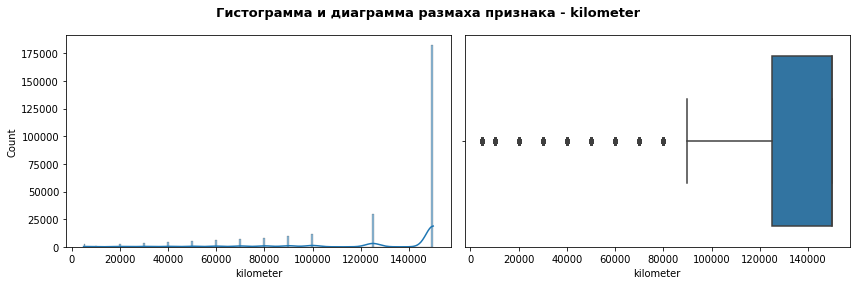

count    272728.000000
mean     128807.163181
std       36326.384665
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

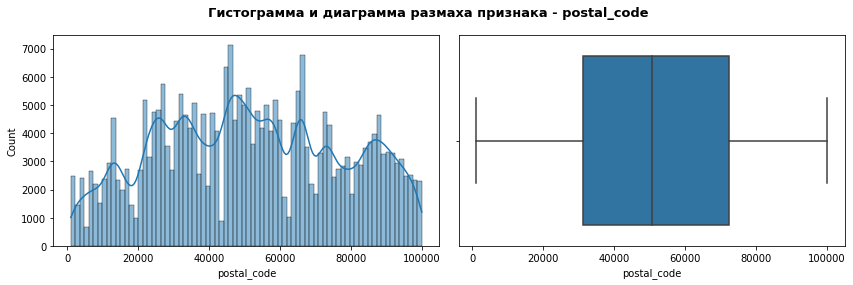

count    272728.000000
mean      51475.105677
std       25778.315286
min        1067.000000
25%       31134.000000
50%       50667.000000
75%       72336.000000
max       99998.000000
Name: postal_code, dtype: float64

In [25]:
histbox_plot(df, num_col_df)

Из диаграмм и таблиц видно, что аномальные значения и выбросы в количественных признаках исключены. Признаки  имеют явно ненормальное распределение: смещение вершин к границам диапазона, несколько вершин, пропуски и т.д. Значения признака `kilometer` вызывают вопросы, как минимум 50% его значений приходится на его максимальное значение в 150_000 км. Возможно при формировании анкеты не было возможности установить большее значение, здесь требуется обращение к эксперту. Признак `PostalCode`, на первый  взгляд, может иметь опосредованное значение для прогноза цены, как признак, указывающий на географию нахождения автомобиля. Решение о его использовании примем на этапе корреляционного анализа данных.

#### Cтатистический анализ категориальных признаков

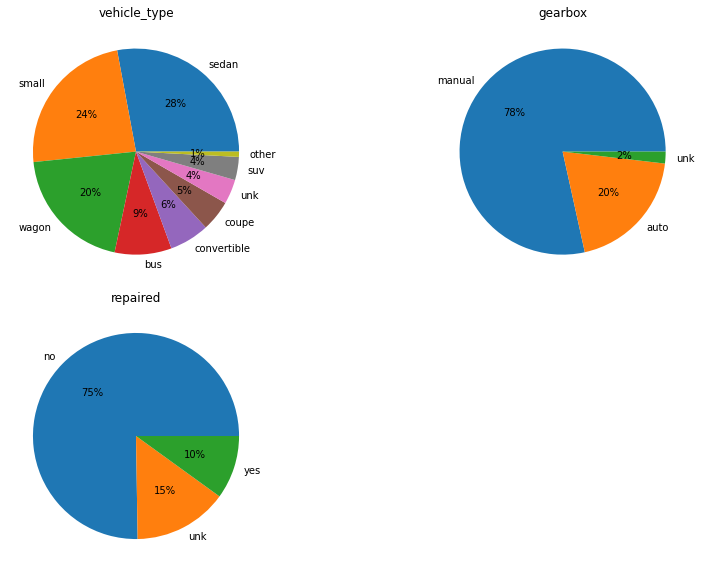

In [26]:
pie_plot(df, ['vehicle_type', 'gearbox', 'repaired'])

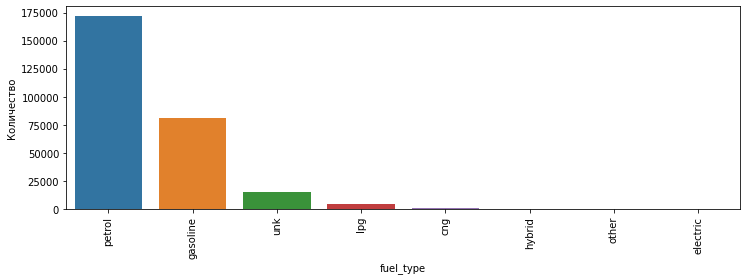

In [27]:
colum_plot(df, ['fuel_type'])

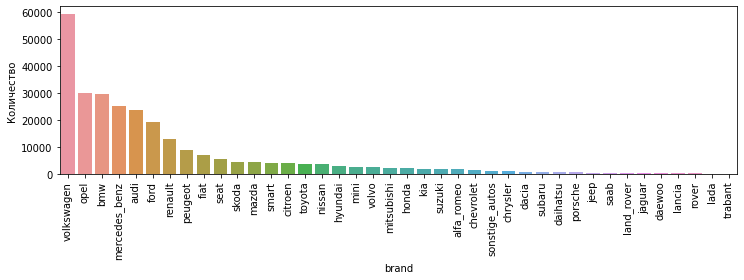

In [28]:
colum_plot(df, ['brand'])

По причине большого количества моделей отобразим 30 наибольших по количеству 

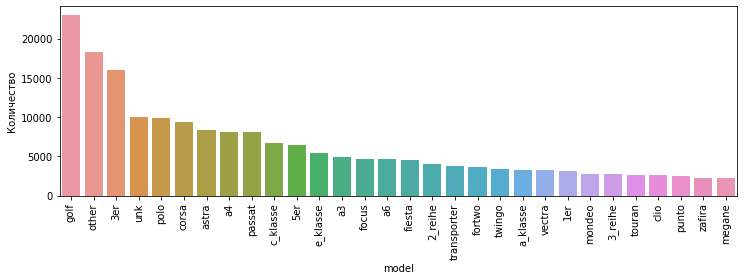

In [29]:
colum_n_plot(df, ['model'])

Из диаграмм и графиков получаем следующую информацию об автомобилях:
- тип кузова `small` и `sedan` занимают половину от общего объема
- почти 80% авто представлены с ручной коробкой передач 
- 75% авто не находилось в ремонте, по 16% информация отсутствует
- большинство авто используют вид топлива `petrol` и `gasoline`
- самыми популярными являются европейские бренды, из которых лидрует `volkswagen` с большим отрывом. Их модель `golf` соответственно является наиболее популярной среди других моделей

### Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем $\phi_k$ матрицу, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

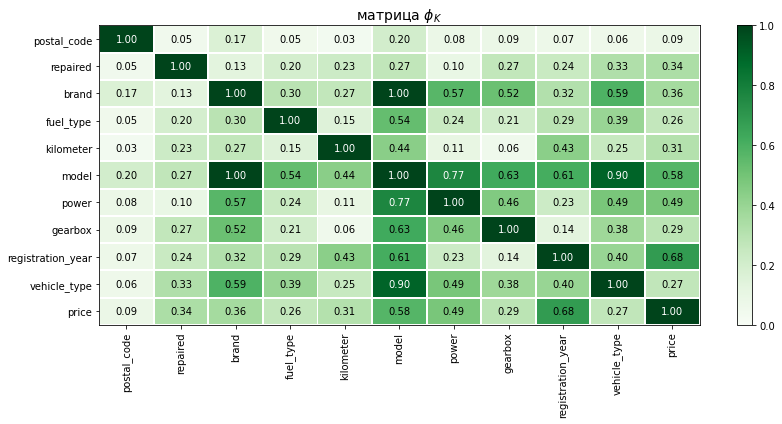

In [30]:
phik_matrix_(df, num_col_df)

**Вывод:** из анализа матрицы видно, что имеется мультиколлинеарность в данных между входными признаками `brand` и `model`, а также близкая к мультиколлинеарности ситуация между  `vehicle_type` и `model`.     
У целевого признака `price` имеется:
- высокая теснота связи с признаком `registration_year` и заметная теснота связи с признаком `model` и `power`, эти параметры действительно крайне важны выборе автомобиля

По другим признакам наблюдается:
- заметная теснота связи параметра `model` c параметрами `registration_year`, `gearbox`, `power` и `fuel_type`, между `brand` и `power`,  `gearbox`, а также между `registration_year` и `vehicle_type`. 

У параметра `model` наблюдается корреляция с большинством праметров, что логично, так как модель автомобиля является определяющей для них и по ней можно восстановить большинство из них, т.е этот параметр наиболее информативен. Принимая это внимание, а также, что модели авто прямо соответствует ее марка, из мультиколлерующей пары `brand` и `model` исключим для дальнейшего обучения моделей параметр `brand`.    
У параметра `postal_code`, как и ожидалось, практически отсутствует корреляция со всеми признаками, также исключим для дальнейшего обучения моделей.

In [31]:
df = df.drop(['brand', 'postal_code'], axis=1)

In [32]:
df.duplicated().sum()

18740

In [33]:
df = df.drop_duplicates()
df.shape

(253988, 9)

## Обучение моделей

Для подбора модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров `RandomizedSearchCV`. Выбор лучшей модели будет осуществляться на основе метрики — `RMSE`

В рамках пайплайна использовались следующие инструменты:    

для кодирования категориальных признаков:
- OneHotEncoder 

для масштабирования количественных признаков:
- StandardScaler, MinMaxScaler, RobustScaler, без масштабирования

типы методов:
- LinearRegression, Ridge, Lasso, DecisionTreeRegressor, LGBMRegressor,  CatBoostRegressor со своими настройками гиперпараметров

Путем проведения серии обучения моделей с подбором гиперпараметров, были определены их оптимальные значения, которые были зафиксированы в приведенном ниже пайплайне.

Выделим количественные и категориальные признаки

In [34]:
num_col_df = df.select_dtypes(include='number').columns.tolist()
cat_col_df = df.select_dtypes(exclude='number').columns.tolist()
print(num_col_df)
print(cat_col_df)

['price', 'registration_year', 'power', 'kilometer']
['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']


In [35]:
%%time
# разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['price'], axis=1),
    df['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

# создаём списки с названиями признаков
ohe_columns = cat_col_df
num_columns = num_col_df[1:]

# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', None)
])

param_grid = [

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__fit_intercept': [True],
        'preprocessor__num': [StandardScaler()]  
    },
    
    # словарь для модели Lasso()
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [2.9],
        'models__tol': [0.0001],
        'preprocessor__num': [StandardScaler()]  
    },
    
    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [1.8],
        'models__tol': [0.01],
        'preprocessor__num': [MinMaxScaler()]  
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [19],
        'models__min_samples_leaf': [8],
        'models__min_samples_split': [7]
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': [50],
        'models__learning_rate': [0.1],
        'models__n_estimators': [200],
        'models__max_depth': [-1],
        'models__feature_fraction': [0.8]
    },
    
    # Параметры для CatBoostRegressor()
    {
        'models': [CatBoostRegressor(verbose=0)],
        'models__depth': [10],
        'models__learning_rate': [0.1],
        'models__iterations': [200]
    }
    
]
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=6
)
randomized_search.fit(X_train, y_train)

display('Лучшая модель и её параметры:', randomized_search.best_params_)
print (f'Метрика RMSE, полученная с помощью кросс-валидации: {randomized_search.best_score_ * -1:.1f}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


'Лучшая модель и её параметры:'

{'models__num_leaves': 50,
 'models__n_estimators': 200,
 'models__max_depth': -1,
 'models__learning_rate': 0.1,
 'models__feature_fraction': 0.8,
 'models': LGBMRegressor()}

Метрика RMSE, полученная с помощью кросс-валидации: 1607.4
CPU times: user 5min 21s, sys: 41.6 s, total: 6min 2s
Wall time: 6min 6s


**Вывод:** моделью, показавшей наилучшие результаты метрики `RMSE` на кроссвалидационной выборке, стала `LGBMRegressor` с параметрами: максимальное количество листьев в одном дереве - 50, скорость обучения - 0.1, количество деревьев в ансамбле - 200, максимальная глубина деревьев не ограничена, доля признаков, используемых для обучения каждого дерева - 0.8

Дополнительно были подобраны гиперпараметры и обучена модель `SGDRegressor`, но по причине невысокой метрики ~  2450, модель была исключена из пайплайна для экономии времени.

## Анализ моделей

Сохраним результаты работы со всеми моделями в result

In [36]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[
    ['rank_test_score', 'param_models', 'mean_test_score','params', 'mean_fit_time']
    ].sort_values('rank_test_score')
result

,rank_test_score,param_models,mean_test_score,params,mean_fit_time
4,1,LGBMRegressor(),-1607.355702,"{'models__num_leaves': 50, 'models__n_estimators': 200, 'models__max_depth': -1, 'models__learning_rate': 0.1, 'models__feature_fraction': 0.8, 'models': LGBMRegressor()}",17.598766
5,2,<catboost.core.CatBoostRegressor object at 0x7fc1138e1070>,-1668.033350,"{'models__learning_rate': 0.1, 'models__iterations': 200, 'models__depth': 10, 'models': <catboost.core.CatBoostRegressor object at 0x7fc1138e1070>}",22.177560
3,3,DecisionTreeRegressor(random_state=42),-1825.425815,"{'models__min_samples_split': 7, 'models__min_samples_leaf': 8, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=42)}",4.161663
0,4,LinearRegression(),-2481.197011,"{'preprocessor__num': StandardScaler(), 'models__fit_intercept': True, 'models': LinearRegression()}",12.301988
2,5,Ridge(random_state=42),-2481.285791,"{'preprocessor__num': MinMaxScaler(), 'models__tol': 0.01, 'models__alpha': 1.8, 'models': Ridge(random_state=42)}",2.387171
1,6,Lasso(random_state=42),-2575.187494,"{'preprocessor__num': StandardScaler(), 'models__tol': 0.0001, 'models__alpha': 2.9, 'models': Lasso(random_state=42)}",4.986738


In [37]:
result_fin = result.drop(['params'], axis=1)

# Рассчитаем время обучения с учетом кросс-валидации
result_fin['mean_fit_time'] *= 5

result_fin.columns = ['Место', 'Модель', 'Метрика RMSE',  'Время обучения с учетом кросс-вал, сек']

print('\n                            Таблица анализа моделей по возрастанию метрики')
display(result_fin)
print('\n                       Таблица анализа моделей по возрастанию времени обучения')
display(result_fin.sort_values('Время обучения с учетом кросс-вал, сек'))


                            Таблица анализа моделей по возрастанию метрики


,Место,Модель,Метрика RMSE,"Время обучения с учетом кросс-вал, сек"
4,1,LGBMRegressor(),-1607.355702,87.993829
5,2,<catboost.core.CatBoostRegressor object at 0x7fc1138e1070>,-1668.033350,110.887798
3,3,DecisionTreeRegressor(random_state=42),-1825.425815,20.808316
0,4,LinearRegression(),-2481.197011,61.509940
2,5,Ridge(random_state=42),-2481.285791,11.935855
1,6,Lasso(random_state=42),-2575.187494,24.933690



                       Таблица анализа моделей по возрастанию времени обучения


,Место,Модель,Метрика RMSE,"Время обучения с учетом кросс-вал, сек"
2,5,Ridge(random_state=42),-2481.285791,11.935855
3,3,DecisionTreeRegressor(random_state=42),-1825.425815,20.808316
1,6,Lasso(random_state=42),-2575.187494,24.933690
0,4,LinearRegression(),-2481.197011,61.509940
4,1,LGBMRegressor(),-1607.355702,87.993829
5,2,<catboost.core.CatBoostRegressor object at 0x7fc1138e1070>,-1668.033350,110.887798


**Вывод:** моделью, показавшей наилучшие результаты на кроссвалидационной выборке, стала `LGBMRegressor` со значением метрики RMSE `1607,4`(при этом при увеличении количество деревьев в ансамбле модель `CatBoostRegressor` начинает показывать даже лучшие результаты, но резко увеличивается время обучения). Моделью с минимальным временем обучения и приемлимой метрикой по условию задания 2481,3 стала `Ridge`.      

С учетом значительного лучшего результата метрики выберем в качестве оптимальной модель `LGBMRegressor`. Рассчитаем на ее основе прогноз и метрику RMSE на тестовых данных.

In [38]:
y_pred = randomized_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Метрика RMSE на тестовых данных: {rmse:.1f}\n')

Метрика RMSE на тестовых данных: 1595.4



С учетом вышеизложенного модель `LGBMRegressor` будет рекомендована Заказчику для использования в приложении по определению рыночной стоимости автомобиля. 

## Общий вывод

**В рамках проекта была проведена:** предобработка данных, исследовательский анализ данных с необходимой визуализацией, статистический анализ признаков по типам, изучена взаимосвязь между признаками на основе корреляционного анализа.    
С целью прогноза рыночной стоимости автомобиля обучены шесть моделей, расчитана метрика `RMSE` и отобрана лучшая модель на основе данной метрики. Проведен сравнительный анализ времени обучения и качества моделей.
_____________

**На этапе предобработки данных:** по результатам предобработки данных названия столбцов были приведены к "змеиному типу", заменили некорректное наименование марки автомобиля, выявленные в данных пропуски заполнены значением `unk` (неизвестно), таким образом, получена отдельная категория данных.    

**На этапе исследовательского анализа данных:** проведен предварительный отбор признаков, которые явно не могли иметь отношения к прогнозу целевого признака или являлись неинформативными: `date_crawled`, `date_created`, `last_seen`, `registration_month`, `number_of_pictures` и исключили их. Более глубоко исследованы количественные и категориальные данные с использованием графических инструментов, описаны характеристики данных. Были обработаны аномальные значения в признаках `price`, `registration_year`, `power`.

**На этапе корреляционного анализа признаков:** изучена взаимосвязь между всеми признаками на основе матрицы Phik. Из анализа матрицы видно, что имеется мультиколлинеарность в данных между входными признаками `brand` и `model`, а также близкая к мультиколлинеарности ситуация между `vehicle_type` и `model`.     
У целевого признака `price` имеется:
- высокая теснота связи с признаком `registration_year` и заметная теснота связи с признаком `model` и `power`, эти параметры действительно крайне важны выборе автомобиля

По другим признакам наблюдается:
- заметная теснота связи параметра `model` c параметрами `registration_year`, `gearbox`, `power` и `fuel_type`, между `brand` и `power`,  `gearbox`, а также между `registration_year` и `vehicle_type`. 

Принимая во внимание, что параметр `model` наиболее информативен, а также, что модели авто прямо соответствует ее марка, из мультиколлерующей пары `brand` и `model` исключили для дальнейшего обучения моделей параметр `brand`. У параметра `postal_code`, практически отсутствует корреляция со всеми признаками, также исключили для дальнейшего обучения моделей.

**На этапе обучения и выбора лучшей модели:** с использованием пайплайнов обработаны количественные и категориальные признаки, обучены 6 моделей: `LinearRegression`, `Ridge`, `Lasso`, `DecisionTreeRegressor`, `LGBMRegressor`,  `CatBoostRegressor`. Для каждой из моделей подобраны гиперпараметры. Для выбора лучшей модели использовалась заданная метрика `RMSE`.       

Моделью, показавшей наилучшие результаты метрики `RMSE` на кроссвалидационной выборке, стала `LGBMRegressor` с параметрами: максимальное количество листьев в одном дереве - 50, скорость обучения - 0.1, количество деревьев в ансамбле - 200, максимальная глубина деревьев не ограничена, доля признаков, используемых для обучения каждого дерева - 0.8.    
С использованием данной модели `RMSE`, полученная с помощью кросс-валидации, составила `1607,4`

**На этапе анализа моделей:** проведен сравнительный анализ времени обучения и качества моделей. Моделью, показавшей наилучшие результаты на кроссвалидационной выборке, стала `LGBMRegressor` со значением метрики RMSE `1607,4`, следующей по качеству метрики идет модель `CatBoostRegressor `. Моделью с минимальным временем обучения и приемлимой метрикой по условию задания 2416,9 стала `Ridge`.

С учетом значительного лучшего результата метрики выберем в качестве оптимальной модель `LGBMRegressor`.    
С использованием данной модели `RMSE`, полученная на тестовых данных, составила `1595,4`

С учетом вышеизложенного модель `LGBMRegressor` будет рекомендована Заказчику для использования в приложении по определению рыночной стоимости автомобиля. 